In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import pickle
import pmdarima as pm

## 1) Importing Data 

In [2]:
sp500=yf.download('^GSPC',start="2000-01-01", end="2004-12-31",interval='1d')

[*********************100%***********************]  1 of 1 completed


In [3]:
sp500.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000


In [4]:
sp500['Returns %']=sp500['Adj Close'].diff() / sp500['Adj Close']

In [5]:
sp500.head()

,Open,High,Low,Close,Adj Close,Volume,Returns %
Date,,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000,NaN
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000,-0.039874
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000,0.001918
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000,0.000955
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000,0.026376


<AxesSubplot:xlabel='Date'>

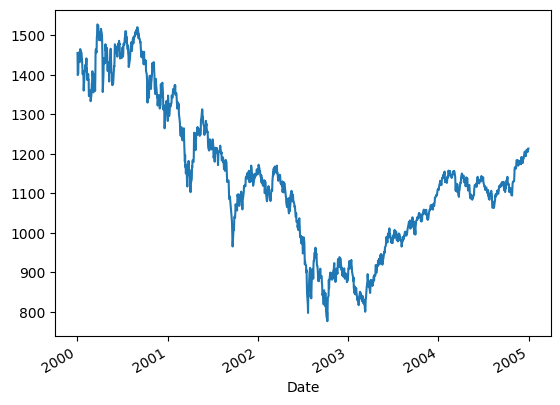

In [6]:
sp500['Adj Close'].plot()

<AxesSubplot:xlabel='Date'>

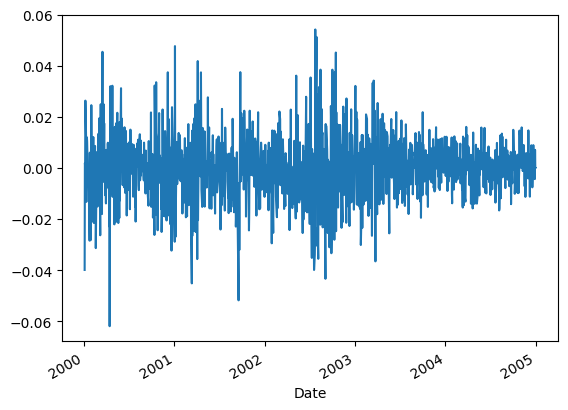

In [7]:
sp500['Returns %'].plot()

In [8]:
# sp500['Adj Close'].ewm(span=100).mean().plot()

In [9]:
# sp500['Adj Close']=sp500['Adj Close'].ewm(span=80).mean()

<AxesSubplot:xlabel='Date'>

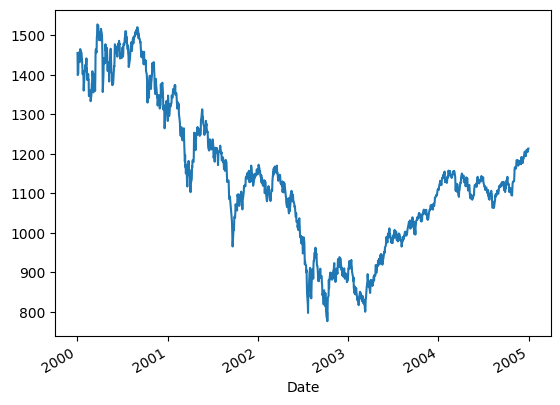

In [10]:
sp500['Adj Close'].plot()

The cyclical component represents phenomena that happen across seasonal periods. Cyclical patterns do not have a fixed period like seasonal patterns do. An example of a cyclical pattern is the cycles of boom and bust that stock markets experience in response to world events. <br>
This data seems to have cyclical component with no consistent cyclicity. So instead of decomposing it into trend, seasonality, noise, we would just keep it as it is.

In [11]:
sp500['Adj Close'].shape

(1255,)

Figure(640x480)


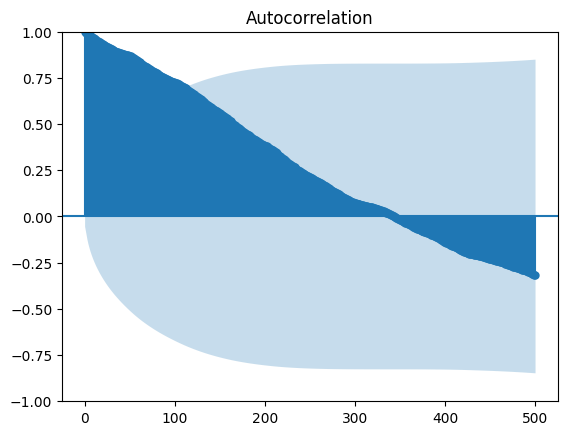

In [12]:
print(plot_acf(sp500['Adj Close'],lags=500))

Also autocorrelation graph shows no seasonal pattern.

## 4) Model

In [13]:
sar = sm.tsa.statespace.SARIMAX(np.log(sp500.loc[~np.isnan(np.array(sp500['Returns %'])),'Returns %']+1), 
                                order=(2,0,1), 
                                seasonal_order=(1,0,0,40), 
                                trend='c').fit()
sar.summary()

# sarima model without seasonality is arima model

C:\Users\hp\miniconda3\envs\kirtesh\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hp\miniconda3\envs\kirtesh\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                           Returns %   No. Observations:                 1254
Model:             SARIMAX(2, 0, 1)x(1, 0, [], 40)   Log Likelihood                3693.961
Date:                             Fri, 10 Mar 2023   AIC                          -7375.921
Time:                                     01:50:28   BIC                          -7345.117
Sample:                                          0   HQIC                         -7364.342
                                            - 1254                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0002      0.000     -0.818      0.413      -0.001       0.000
ar.L1          0.3637      0.397      0.916      0.360      -0.415       1.142
ar.L2         -0.0361      0.028     -1.272      0.203      -0.092       0.020
ma.L1         -0.3858      0.397     -0.972      0.331      -1.164       0.392
ar.S.L40      -0.0316      0.025     -1.259      0.208      -0.081       0.018
sigma2         0.0002   4.71e-06     34.320      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               173.42
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.31   Skew:                            -0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [61]:
'''sar = sm.tsa.statespace.SARIMAX(np.log(sp500.loc[~np.isnan(np.array(sp500['Returns %'])),'Returns %']+1), 
                                order=(1,0,1), 
                                seasonal_order=(0,0,0,0), 
                                trend='c').fit()
sar.summary() '''

"sar = sm.tsa.statespace.SARIMAX(np.log(sp500.loc[~np.isnan(np.array(sp500['Returns %'])),'Returns %']+1), \n                                order=(1,0,1), \n                                seasonal_order=(0,0,0,0), \n                                trend='c').fit()\nsar.summary() "

In [62]:
# non seasonal
pm.auto_arima(np.log(sp500.loc[~np.isnan(np.array(sp500['Returns %'])),'Returns %']+1),start_p=1, start_q=1,
                           max_p=3, max_q=3, m=50, 
                           start_P=1, D=0, start_Q=1, max_P=3, max_D=0, max_Q=3,
                               seasonal=False,
                           d=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

C:\Users\hp\miniconda3\envs\kirtesh\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (50) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-7379.148, Time=0.50 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-7380.868, Time=0.30 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-7379.366, Time=0.22 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-7379.412, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-7379.596, Time=0.58 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 1.832 seconds


ARIMA(order=(0, 0, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [63]:
# seasonal
pm.auto_arima(np.log(sp500.loc[~np.isnan(np.array(sp500['Returns %'])),'Returns %']+1),start_p=1, start_q=1,
                           max_p=3, max_q=3, m=50, 
                           start_P=1, D=0, start_Q=1, max_P=3, max_D=0, max_Q=3,
                               seasonal=True,
                           d=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[50] intercept   : AIC=-7374.471, Time=46.57 sec
 ARIMA(0,0,0)(0,0,0)[50] intercept   : AIC=-7379.596, Time=0.59 sec
 ARIMA(1,0,0)(1,0,0)[50] intercept   : AIC=-7376.177, Time=20.46 sec
 ARIMA(0,0,1)(0,0,1)[50] intercept   : AIC=-7376.018, Time=35.41 sec
 ARIMA(0,0,0)(0,0,0)[50]             : AIC=-7380.868, Time=0.37 sec
 ARIMA(0,0,0)(1,0,0)[50] intercept   : AIC=-7377.640, Time=11.95 sec
 ARIMA(0,0,0)(0,0,1)[50] intercept   : AIC=-7377.404, Time=21.39 sec
 ARIMA(0,0,0)(1,0,1)[50] intercept   : AIC=-7375.448, Time=12.14 sec
 ARIMA(1,0,0)(0,0,0)[50] intercept   : AIC=-7378.122, Time=0.63 sec
 ARIMA(0,0,1)(0,0,0)[50] intercept   : AIC=-7378.170, Time=2.51 sec
 ARIMA(1,0,1)(0,0,0)[50] intercept   : AIC=-7378.570, Time=2.18 sec

Best model:  ARIMA(0,0,0)(0,0,0)[50]          
Total fit time: 154.227 seconds


ARIMA(order=(0, 0, 0), scoring_args={}, seasonal_order=(0, 0, 0, 50),
      suppress_warnings=True, with_intercept=False)

In [64]:
'''with open('nifty_08_12.pkl', 'wb') as f:
    pickle.dump(sar, f) '''

"with open('nifty_08_12.pkl', 'wb') as f:\n    pickle.dump(sar, f) "

In [71]:
'''with open('nifty_08_12.pkl', 'rb') as f:
    sar = pickle.load(f) '''

"with open('nifty_08_12.pkl', 'rb') as f:\n    sar = pickle.load(f) "

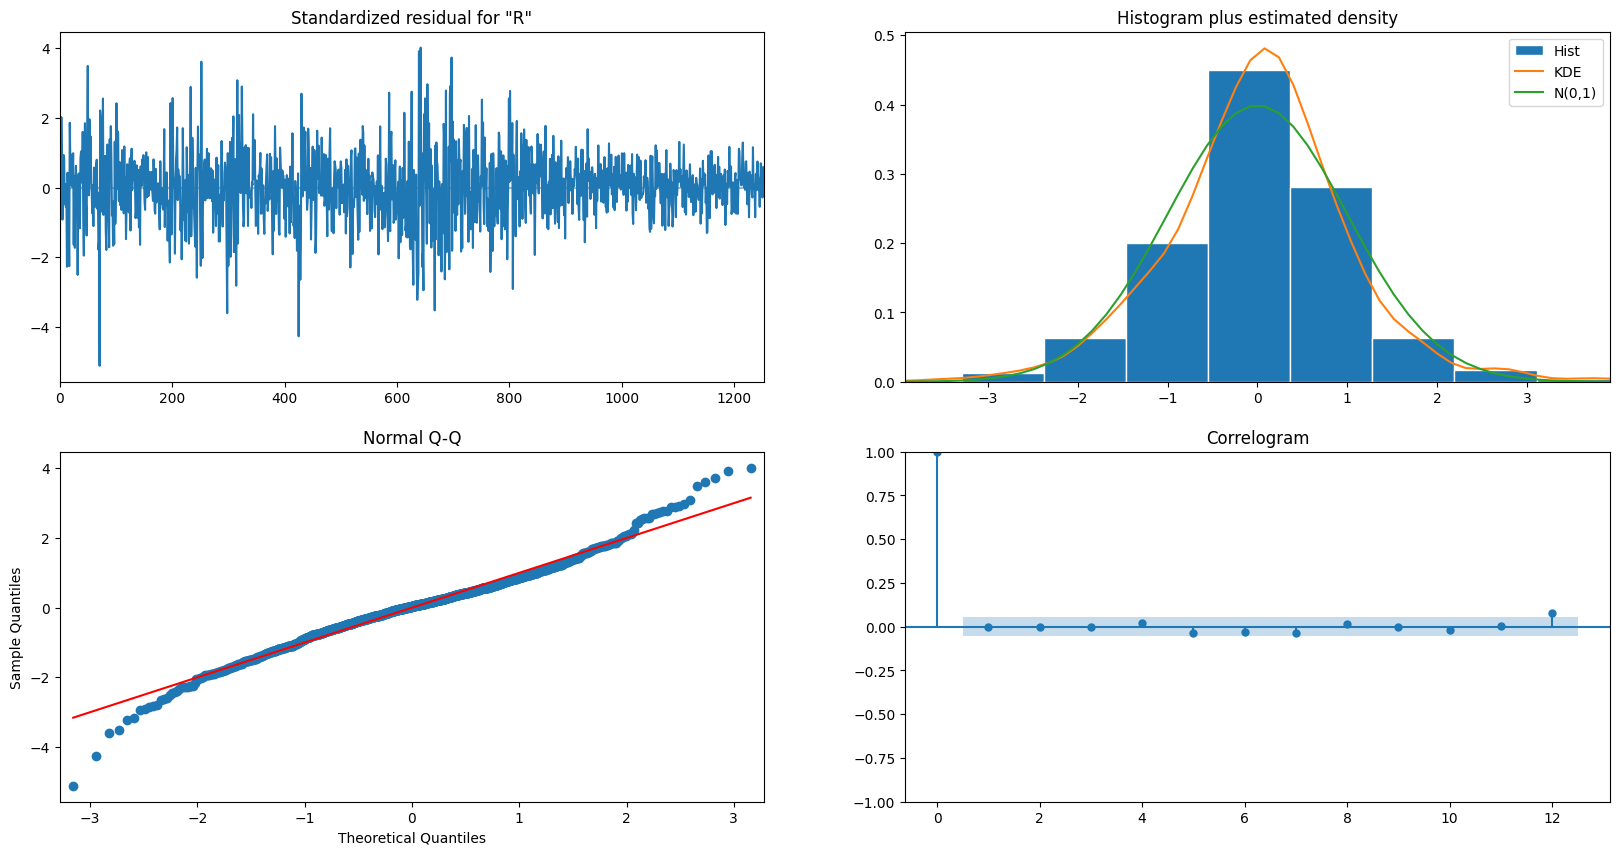

In [15]:
import matplotlib.pyplot as plt
sar.plot_diagnostics(lags=12,figsize = (20,10),)
plt.savefig('ppt_pics/residual_diag_sp500_11_15.png')

<AxesSubplot:xlabel='Date'>

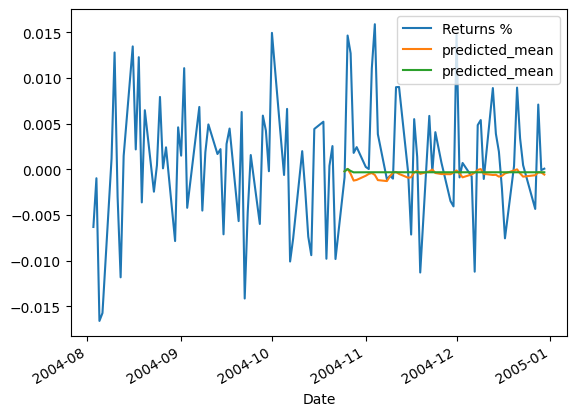

In [75]:
sp500['Returns %'][1150:].plot(legend=True)
sar.predict(start=1207).plot(legend=True)
sar.predict(start=1207,dynamic=True).plot(legend=True)
# sar.forecast(steps=100).plot()
# sp500[730:][['Adj Close', 'Adj Close Forecast']].plot();

In [76]:
def accuracy_sarimax(df1,df2):
    x=np.sign(np.array(df1))==np.sign(np.array(df2))
    
    return sum(x) / len(x)

In [77]:
accuracy_sarimax(np.log(sp500.loc[~np.isnan(np.array(sp500['Returns %'])),'Returns %']+1),sar.predict())

0.5263157894736842

In [67]:
# sp500_fore=yf.download('^GSPC',start="2016-01-01", end="2016-05-15",interval='1d')
# sp500_fore['Adj Close']

In [68]:
# sp500_fore['Returns %']=sp500_fore['Adj Close'].diff() / sp500_fore['Adj Close']

In [69]:
# np.log(sp500_fore.loc[~np.isnan(np.array(sp500_fore['Returns %'])),'Returns %']+1)

In [70]:
# np.log(sp500.loc[~np.isnan(np.array(sp500['Returns %'])),'Returns %']+1).append(sp500_fore['Adj Close'])